In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns
from sklearn import svm, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt

In [3]:
# Define plot settings and predictor sets

%run config.ipynb

In [4]:
df = pd.DataFrame(np.load(r'../data/master_prepared.npy', allow_pickle=True))
cols = np.load(r'../data/columns_prepared.npy', allow_pickle=True)
df.columns = cols

In [5]:
df_agg = df.drop(['companyid', 'eligible'], axis=1).apply(pd.to_numeric).groupby('date').mean()
df_agg.index = df['date'].unique()

# Factors

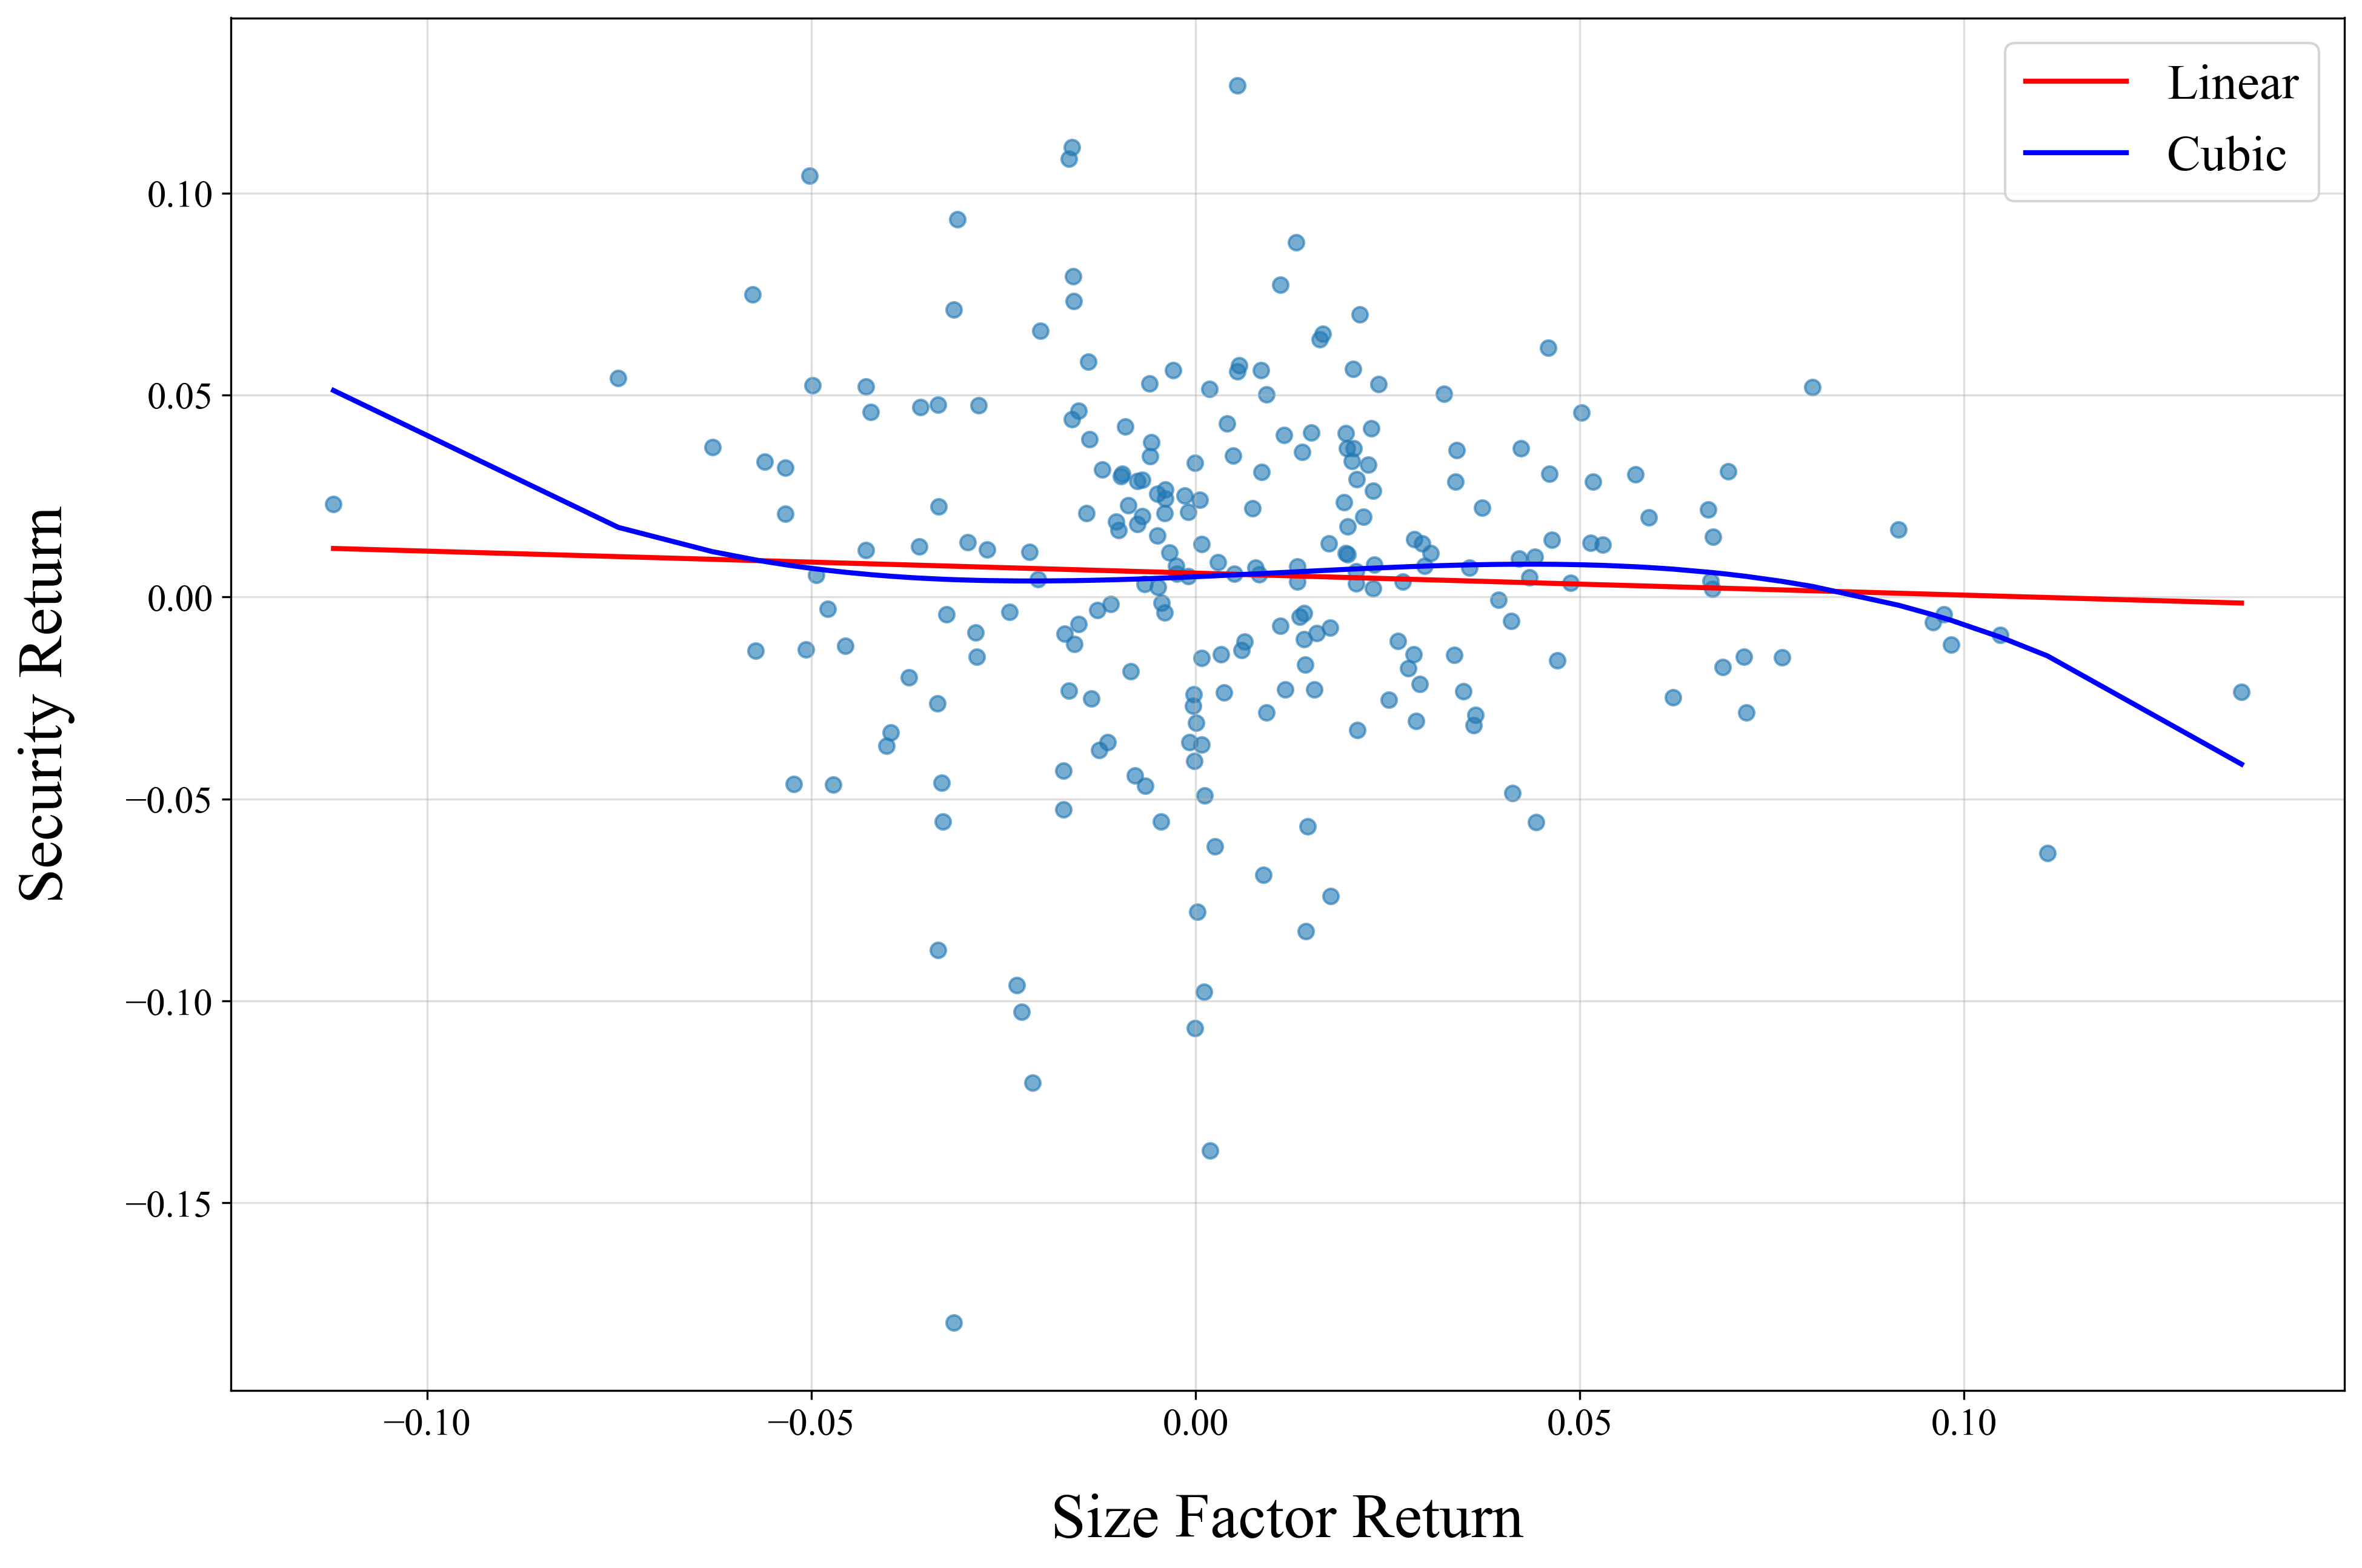

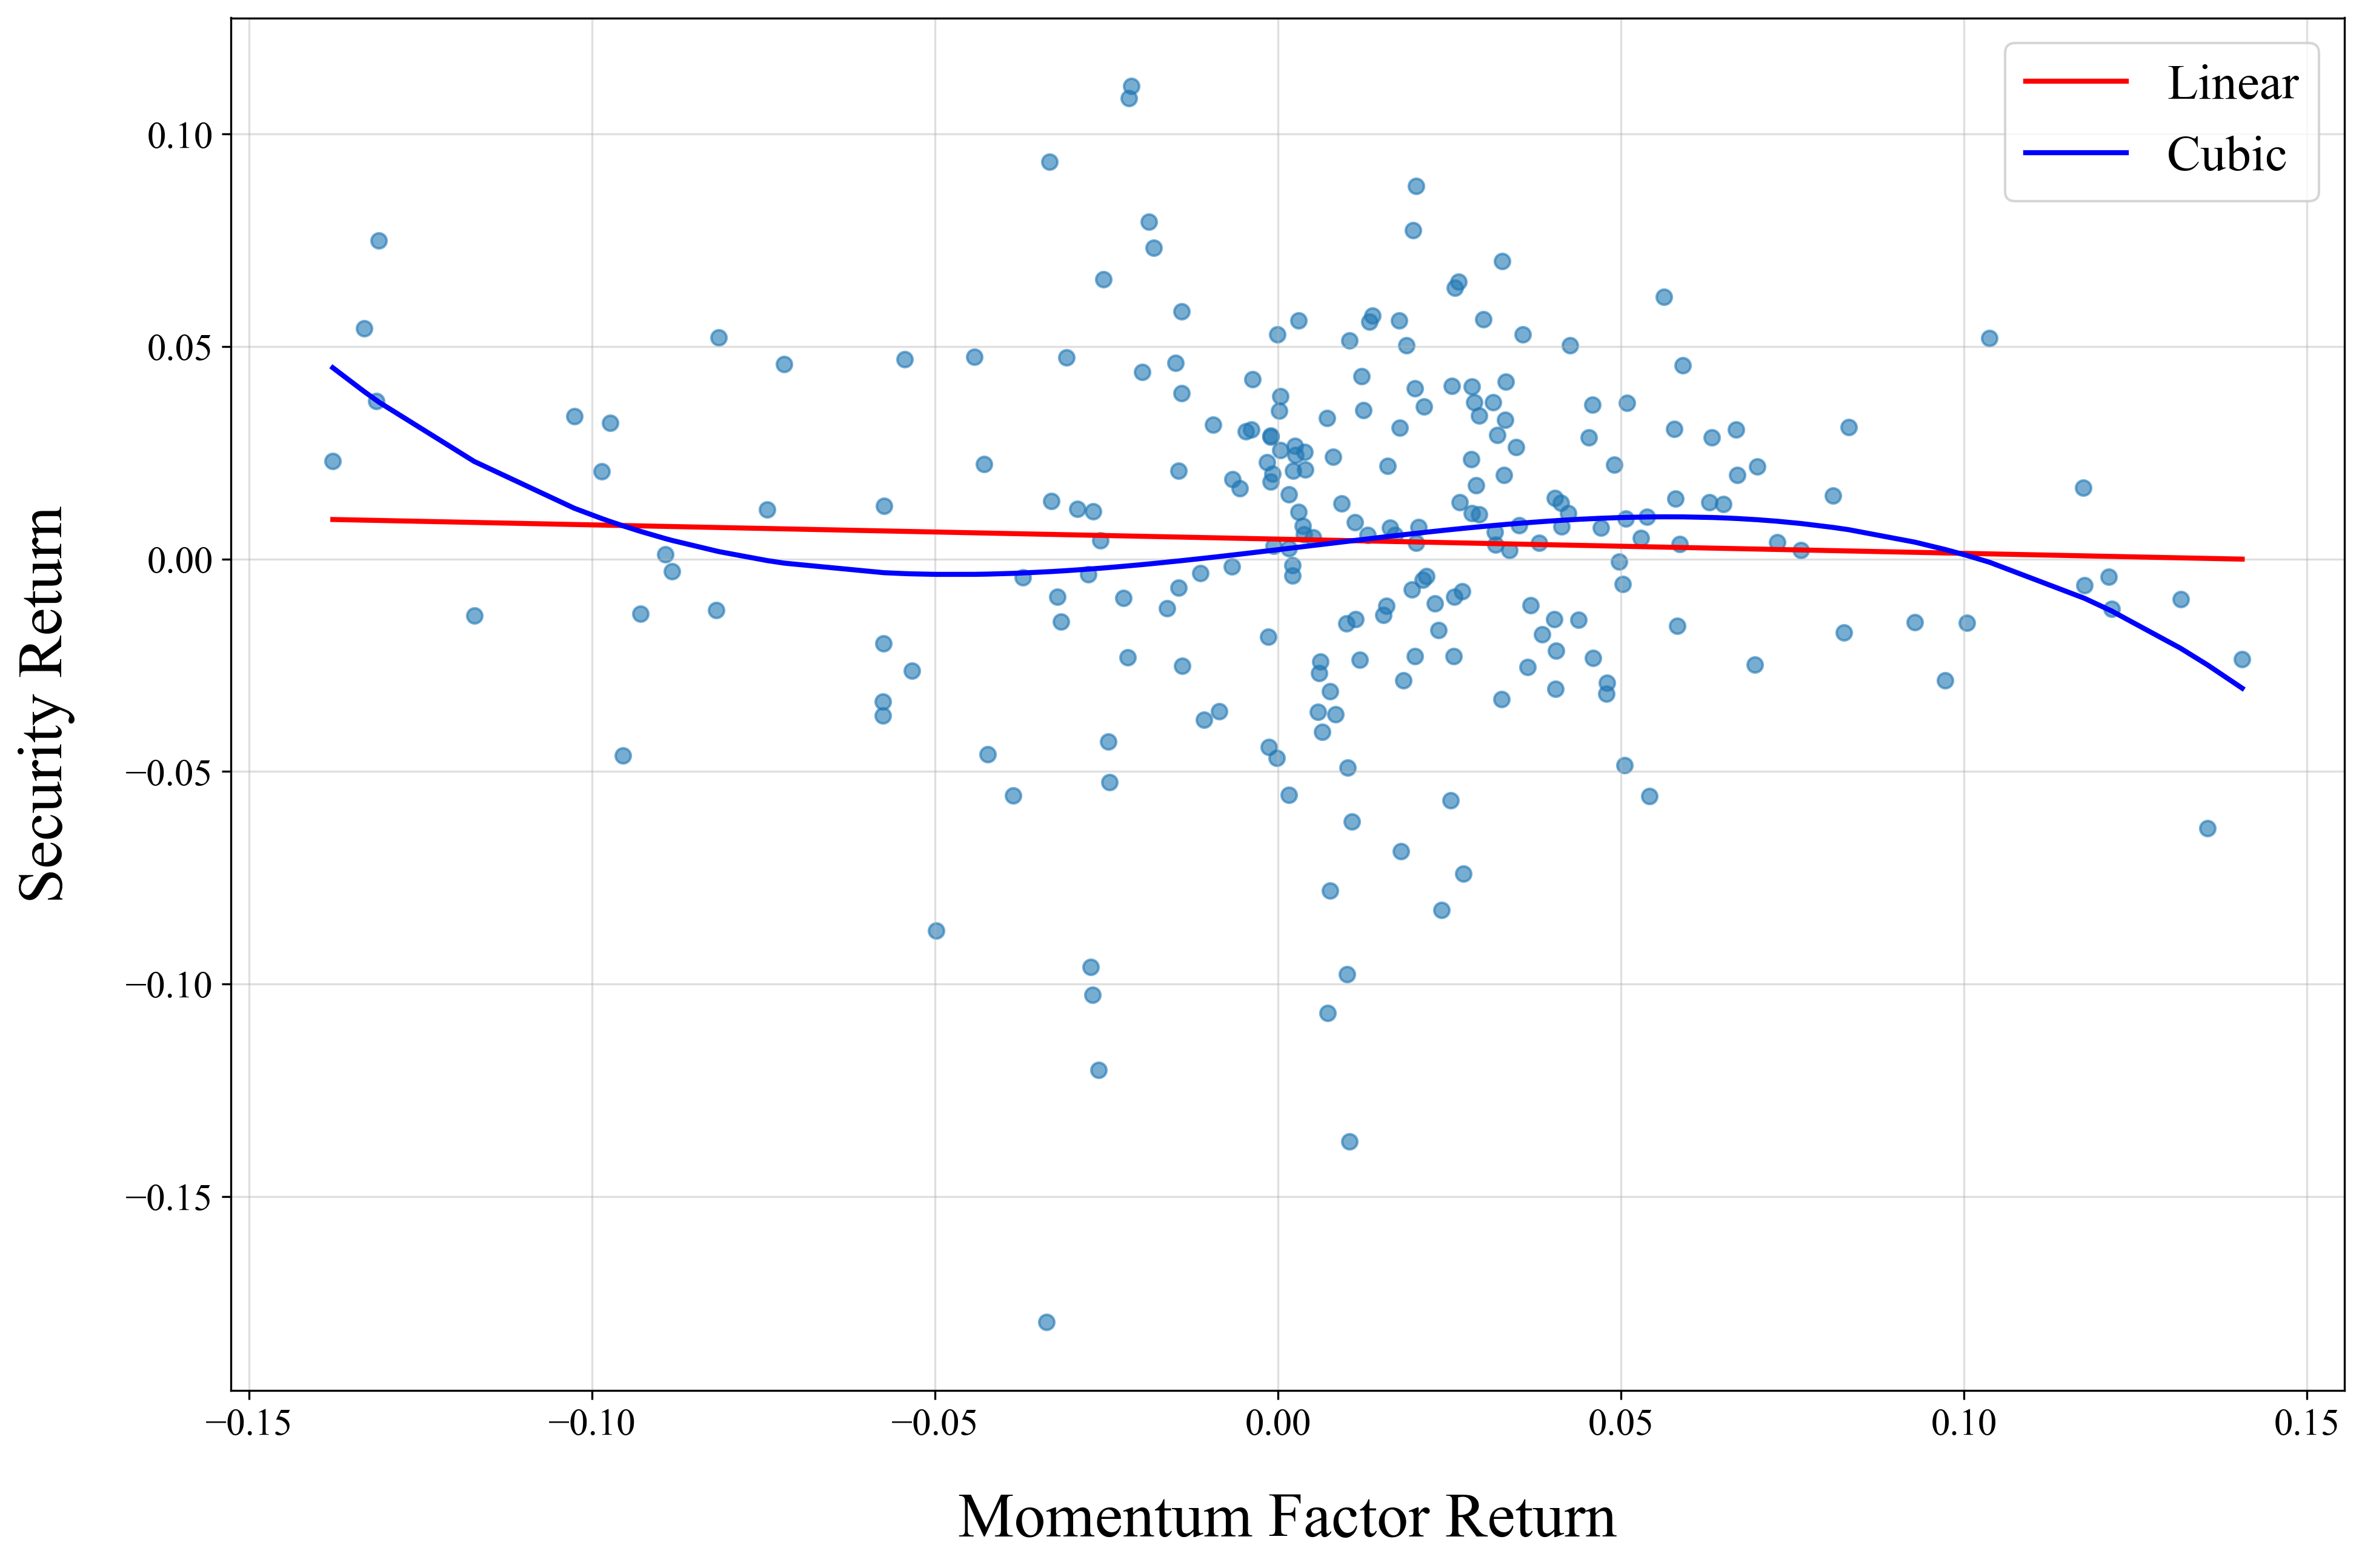

In [5]:

def plot_predictions(x, y, data, xlim, ylim):
    
    # Filter data according to subset
    data = data[data[x].between(xlim[0], xlim[1])]
    data = data[data[y].between(ylim[0], ylim[1])]
    
    # Create cubic predictors
    x_pr = pd.DataFrame(data[[x, x+'_^2', x+'_^3']])
    x_pr.sort_values(by=x, inplace=True)

    # Create linear predictors
    x_lr = pd.DataFrame(x_pr[x])
    
    # Fit a linear regression 
    lr = LinearRegression()
    lr.fit(x_lr, data[y])
    pred_lr = lr.predict(x_lr)
        
    # Fit polynomial regression
    pr = LinearRegression()
    pr.fit(x_pr, data[y])
    pred_pr = pr.predict(x_pr)
    
    # Scatter plot data
    fig, ax = plt.subplots(figsize=[15,10])
    ax.scatter(x_lr, data[y], alpha=0.6)
    
    # Plot predictions
    ax.plot(x_lr, pred_lr, color='red', linewidth=2)
    ax.plot(x_lr, pred_pr, color='blue', linewidth=2, )
    
    ax.legend(['Linear', 'Cubic'])
    
    if y == 'ret_1f1':
        y_ = 'Security Return'
    else:
        y_ = y
    
    ax.set_xlabel(factor_names[x] + ' Factor Return', fontsize=25)
    ax.set_ylabel(y_, fontsize=25)
    
    plt.show()
    

# plot_predictions('MKT', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])
plot_predictions('SMB', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])
# plot_predictions('HML', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])
# plot_predictions('RMW', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])
# plot_predictions('CMA', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])
plot_predictions('UMD', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])
# plot_predictions('VOL', 'ret_1f1', data=df_agg, xlim=[-0.15, 0.15], ylim=[-0.20, 0.20])


# Interaction Effects

In [6]:
corrmat = df[['MKT', 'HML', 'SMB', 'CMA', 'RMW', 'UMD', 'VOL']].astype('float')
corrmat.columns = [factor_names[i] for i in corrmat.columns]



In [20]:


mask = np.triu(np.ones_like(corrmat.corr(), dtype=np.bool))



In [21]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

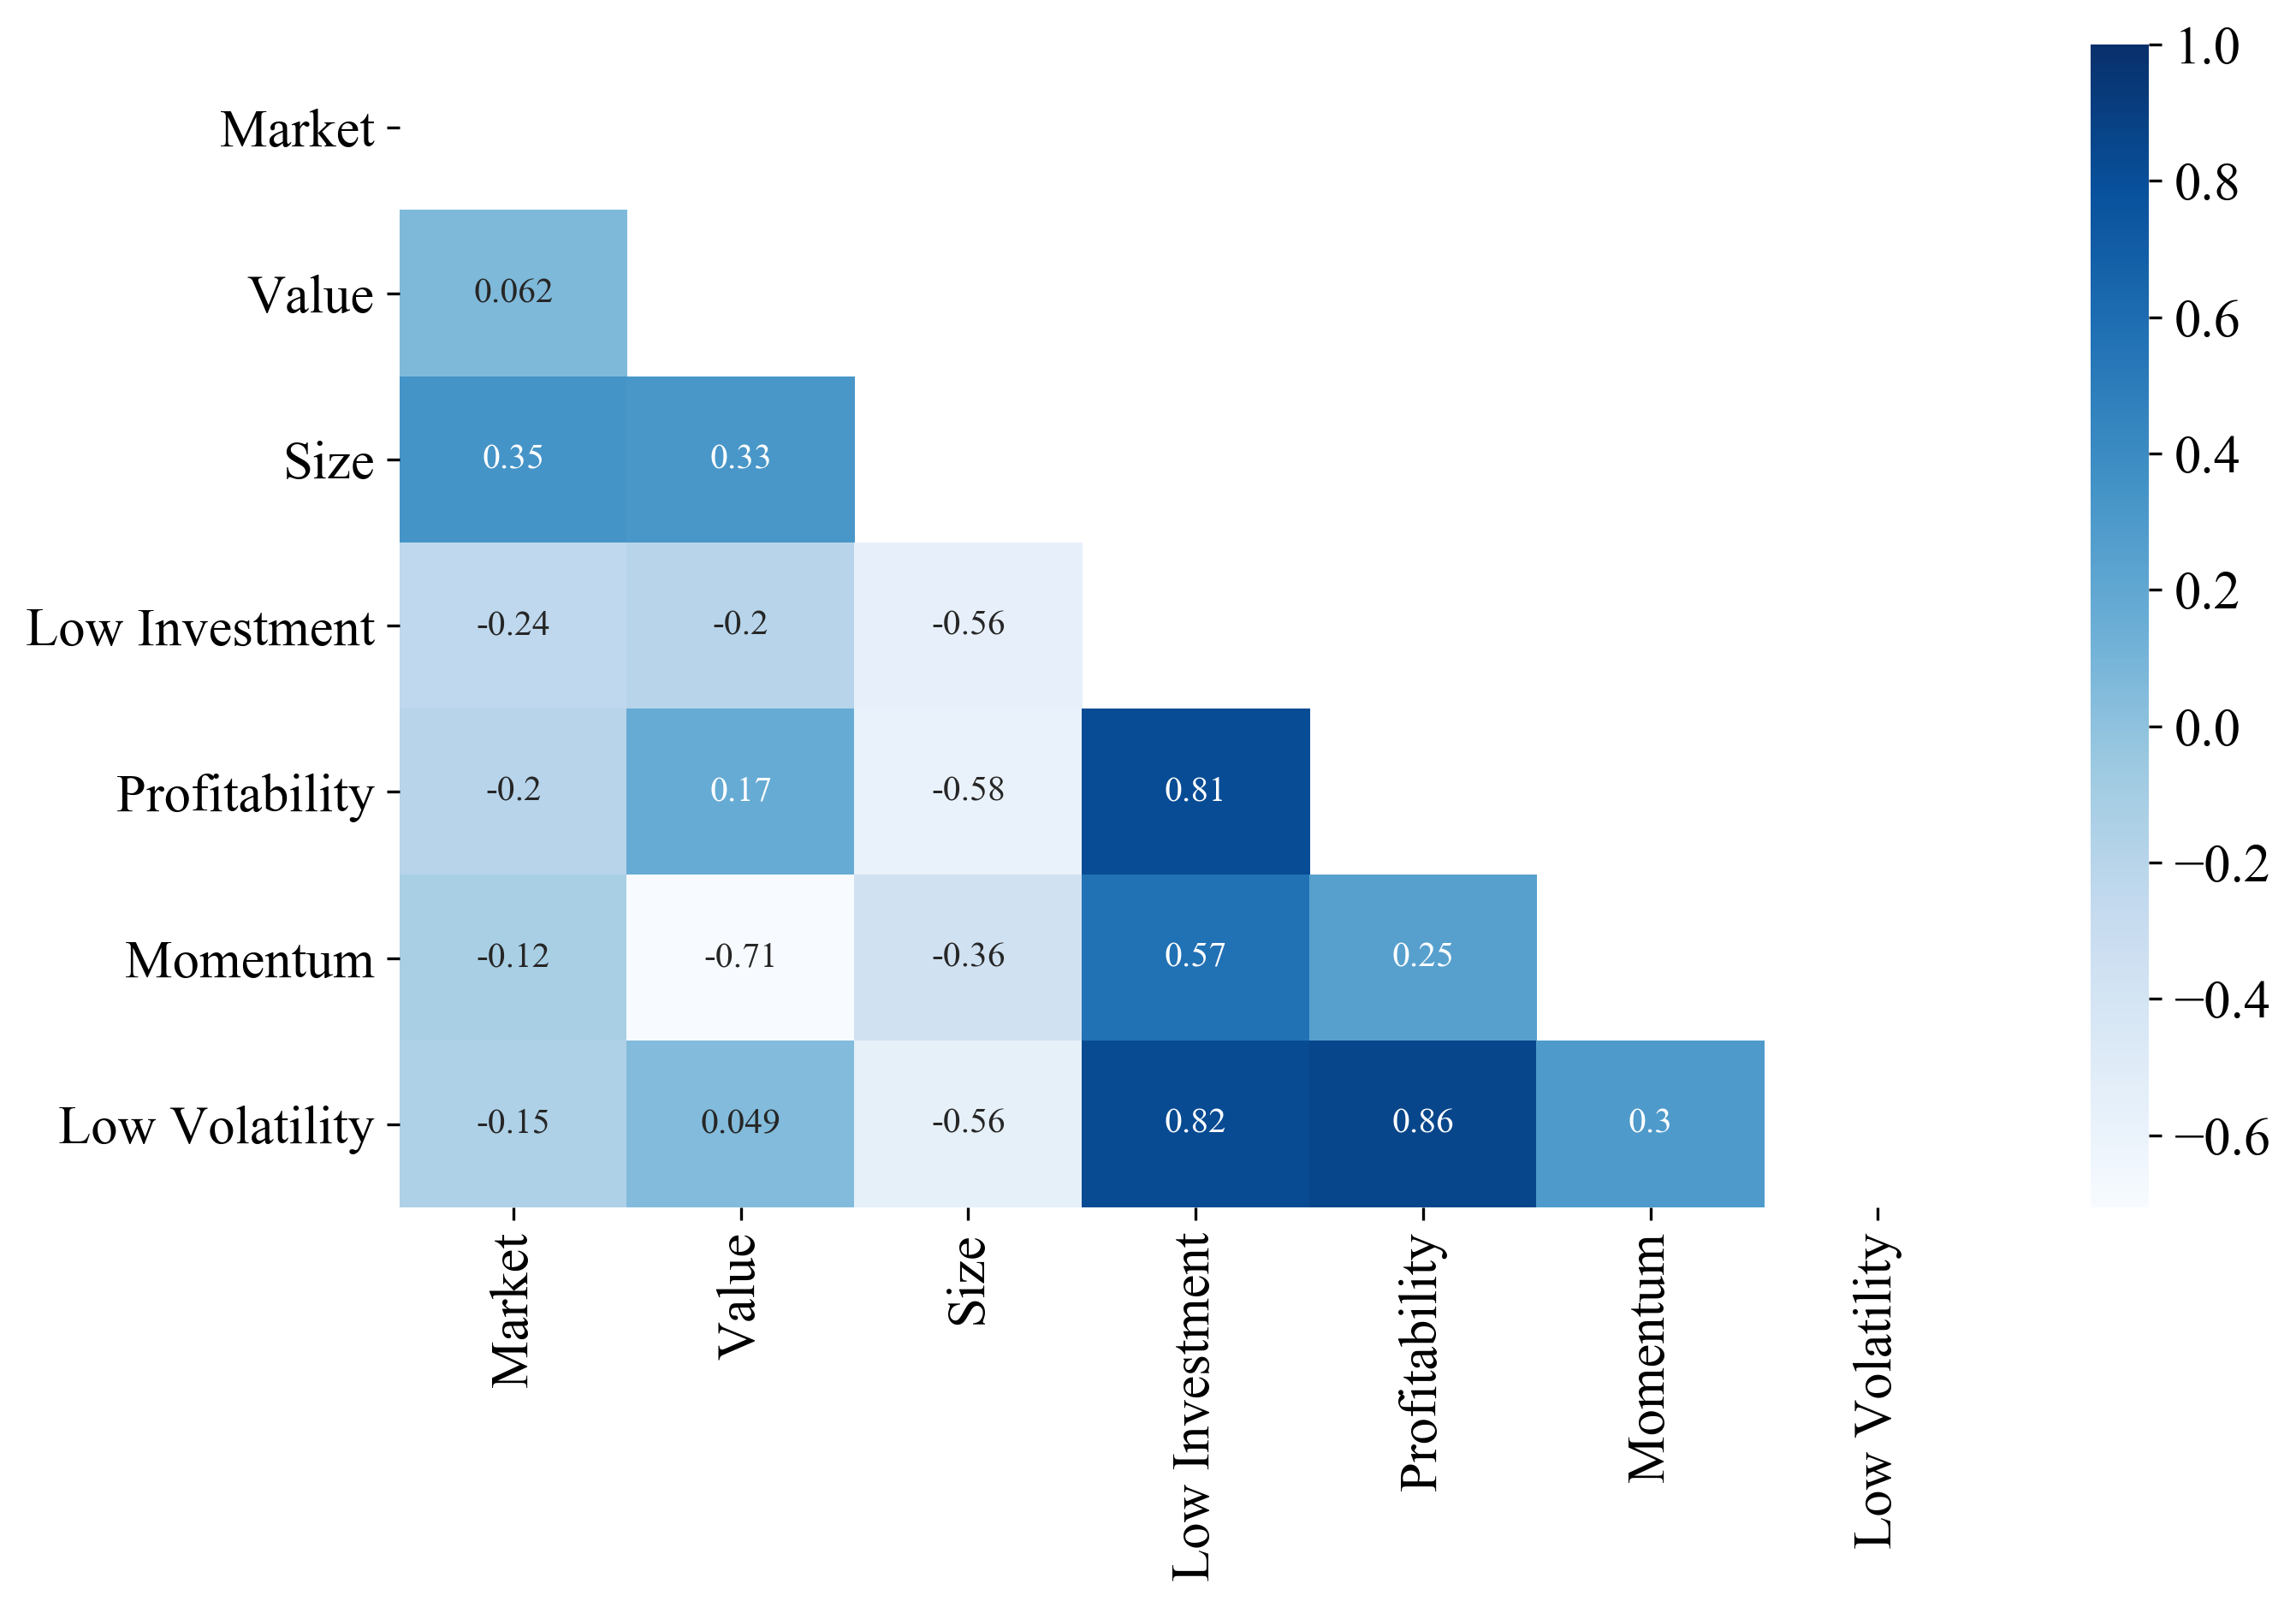

In [22]:


plt.figure(figsize=[10, 6])
sns.heatmap(data=corrmat.corr(), cmap='Blues', annot=True, mask=mask)

# Factor Returns

In [ ]:
df_ = df.copy()
fnames = ['MKT', 'HML', 'SMB', 'CMA', 'RMW', 'UMD', 'VOL']
date_range = df_['date'].unique()[130:]
df_ = df_[df_['date'].isin(date_range)]

factor_indices = pd.DataFrame(index=date_range, columns=fnames)
factor_returns = pd.DataFrame(index=date_range, columns=fnames)

for col in factor_indices.columns:
    factor_returns[col] = df_[col].unique()
    factor_returns[col+'xs'] = factor_returns[col] - factor_returns['MKT']

factor_indices = np.cumprod(1+factor_returns, axis=0) * 100

# Adding a 100 row at the start so all lines begin at same place
factor_plot = pd.concat([pd.DataFrame(data=100, columns=factor_indices.columns, index=[dt.datetime(2009,9,30)]), factor_indices])

fig, ax = plt.subplots(figsize=[15,10])
ax.plot(factor_plot[[i+'xs' for i in fnames]])
for line, name in zip(ax.lines, factor_plot.columns):
    y = line.get_ydata()[-1]
    ax.annotate(factor_names[name], xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=20, va="center")
plt.xlabel('Year')
plt.ylabel('Performance Relative to Market')


In [ ]:
# Sharpe ratio
SR = pd.DataFrame(np.vectorize(round)((factor_returns[factor_names].mean()/factor_returns[factor_names].std()), 3))
SR.columns = ['Sharpe Ratio']
SR